# Volume 3: Gibbs Sampling and LDA
    Eric Manner
    405 Sec 001
    Feb 8 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.stats import norm
from scipy.stats import invgamma
from scipy.stats import gaussian_kde

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$.

In [9]:
def gibbs(y, nu, tau2, alpha, beta, n_samples):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    #initialize the n_samples array
    samples = np.zeros((n_samples,2))
    mu,sigma_2=y.mean(), y.var()
    #generate the first random guess of the distributions
    N = len(y)
    alpha_star = alpha+N/2
    for i in range(n_samples):
        #calculate the new sampling varaiables
        sigma_star_2 = 1/((1/tau2)+(N/sigma_2))
        mu_star = sigma_star_2*((nu/tau2)+y.sum()/sigma_2)
        mu = norm.rvs(mu_star,scale=np.sqrt(sigma_star_2))
        beta_star = beta+np.sum((y-mu)**2)/2
        #create the new distribution and get the samples
        sigma_2 = invgamma.rvs(alpha_star,scale=beta_star)
        #add the samples to the array
        samples[i,:] = np.array([mu,sigma_2])
        
    return samples

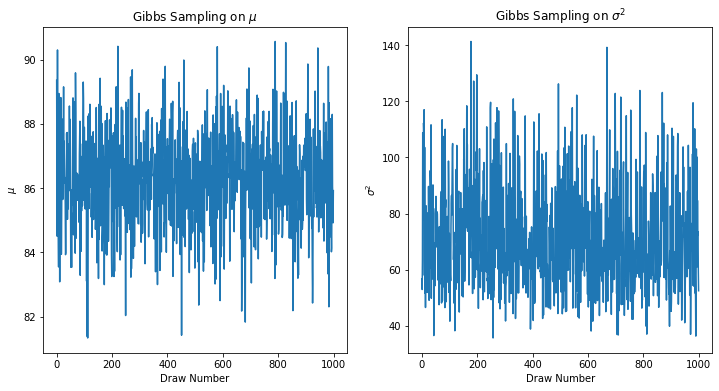

In [10]:
#load the data and set variables
data = np.load("examscores.npy")
nu=80
tau2=16
alpha=3
beta=50
N=1000
#get the resulting draws
draws = gibbs(data,nu,tau2,alpha,beta,N)
mu_draws = draws[:,0]
sigma2_draws = draws[:,1]
#plot the results
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(mu_draws)
ax[0].set_title("Gibbs Sampling on $\mu$")
ax[0].set_xlabel('Draw Number')
ax[0].set_ylabel("$\mu$")
ax[1].plot(sigma2_draws)
ax[1].set_title("Gibbs Sampling on $\sigma^2$")
ax[1].set_xlabel("Draw Number")
ax[1].set_ylabel("$\sigma^2$")
plt.show()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

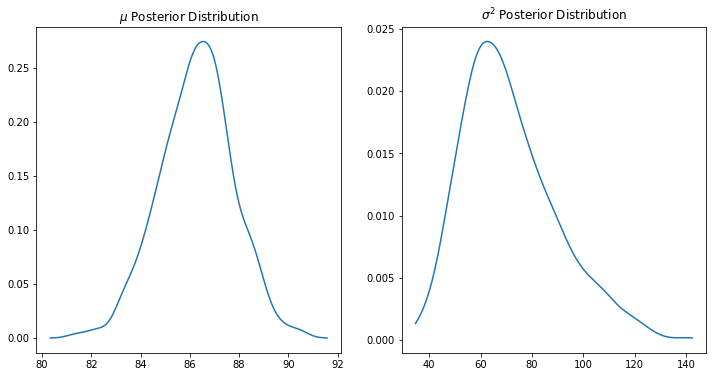

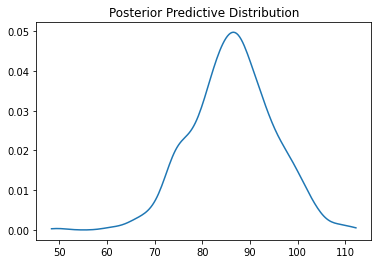

In [11]:
#do the kernel density estimators of the posterior distributions
mu_kernel = gaussian_kde(mu_draws)
x_mu = np.linspace(mu_draws.min()-1,mu_draws.max()+1,200)
sigma_2_kernel = gaussian_kde(sigma2_draws)
x_sigma_2 = np.linspace(min(sigma2_draws)-1,max(sigma2_draws)+1,200)
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(x_mu, mu_kernel(x_mu))
ax[0].set_title("$\mu$ Posterior Distribution")
ax[1].plot(x_sigma_2, sigma_2_kernel(x_sigma_2))
ax[1].set_title("$\sigma^2$ Posterior Distribution")
plt.show()

#now do the posterior predictive distribution
y_samples = [np.random.normal(mu, np.sqrt(sig)) for mu, sig in zip(mu_draws, sigma2_draws)]
kernel = gaussian_kde(y_samples)
x = np.linspace(min(y_samples)-1, max(y_samples)+1, 200)
plt.plot(x, kernel(x))
plt.title("Posterior Predictive Distribution")
plt.show()

## Problem 3

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.
In this method, you will initialize the count matrices (among other things).

To be explicit, you will need to initialize $nmz$, $nzw$, and $nz$ to be zero arrays of the correct size.
Then, in the second for loop, you will assign z to be a random integer in the correct range of topics.
In the increment step, you need to figure out the correct indices to increment by one for each of the three arrays.
Finally, assign $topics$ as given.

## Problem 4

Complete `LDACGS._sweep()`, which needs to iterate through each word of each document.
It should call `LDACGS._conditional()` to get the conditional distribution at each iteration.

Note that the first part of this method will undo what `LDACGS.initialize()` did.
Then we will use the conditional distribution (instead of the uniform distribution we used previously) to pick a more accurate topic assignment.
Finally, the latter part repeats what we did in `LDACGS.initialize()`, but does so using this more accurate topic assignment.

## Problem 5

Complete `LDACGS.sample()`.
The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating your count matrices, by adding `nzw` and `nmz` to `total_nzw` and `total_nmz` respectively, where you only add every `sample_rate`th iteration. 
Also save each log-likelihood.

In [5]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (i,j) entry of self.nmz is the number of words in document i assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        # The (i,j) entry of self.nzw is the number of times term j is assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        # The (i)-th entry is the number of times topic i is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z
        distribution = np.ones(self.n_topics)/self.n_topics
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                z = np.random.multinomial(1, distribution).argmax()
                # Increment count matrices
                self.nzw[z,self.documents[m][i]] += 1
                self.nmz[m,z] += 1
                self.nz[z] += 1
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)]=z
                
    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
            if (i%20 == 0):
                print("Iteration: {}".format(i))
        for i in range(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            #add tracker so that we know where it is
            if ((i+burnin)%20==0):
                print("Iteration: {}".format(i+burnin))
            if not i % sample_rate:
                # accumulate counts
                self.total_nzw += np.copy(self.nzw)
                self.total_nmz += np.copy(self.nmz)
                
    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i-th word in document m.
                w = self.documents[m][i]
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m,i)]
                # Decrement count matrices.
                self.nzw[z,w] -= 1
                self.nmz[m,z] -= 1
                self.nz[z] -= 1
                # Get conditional distribution.
                # Sample new topic assignment.
                z = np.random.multinomial(1,self._conditional(m,w)).argmax()
                # Increment count matrices.
                self.nzw[z,w] += 1
                self.nmz[m,z] += 1
                self.nz[z] += 1
                # Store new topic assignment.
                self.topics[(m,i)] = z

    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How long did it take to burn in?

Iteration: 0
Iteration: 20
Iteration: 40
Iteration: 60
Iteration: 80
Iteration: 100
Iteration: 120
Iteration: 140
Iteration: 160
Iteration: 180


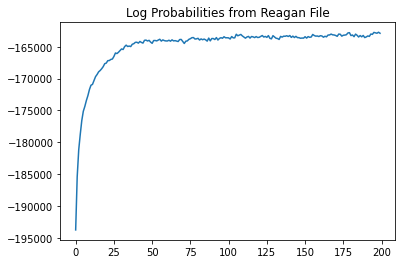

In [6]:
#get the object
reagan_LDACGS = LDACGS(n_topics=20)
#sample plot the results
reagan_LDACGS.sample("reagan.txt",burnin=100,sample_rate=10,n_samples=10,
                   stopwords_file="stopwords.txt")
fig,ax = plt.subplots()
ax.plot(reagan_LDACGS.logprobs)
ax.set_title("Log Probabilities from Reagan File")
plt.show()

#### It took about 50 iterations to burn in!

## Problem 7

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.
If `ntopics=20` and `n=10`, we will get the top $10$ words that represent each of the $20$ topics; for each topic, decide what these ten words jointly represent.

In [8]:
topics = ['Economy','American Dream','Economoic Facts','Party Cooperation','Criminal Justice','Social Economic Programs','Congress Speeches','State of the Union','Support American Democracies','Senate Minutes','Health','American Budget','Nuclear Programs','Education','Foreign Policy','Trade','Make America Great Again']
#do the sorting
for it, t in enumerate([", ".join(sorted(term))+"." for term in reagan_LDACGS.topterms(10)]):
    print(t)
    print('\n')
print("Topics: {}".format(topics))

americans, job, jobs, million, people, propose, special, start, unemployment, work.


america, america., bless, dream, god, men, music, night, you,, you..


--, economic, increase, inflation, interest, percent, program, rate, rates, tax.


bipartisan, commission, hope, join, leader, majority, now,, plan, protect, senate.


--, ago, crime, laws, rights, states, time, united, victims, years.


--, based, economic, economy, full, plan, responsibility, share, tonight, we've.


address, congress, give, joint, let's, president, session, state, union, veto.


--, [laughter], america's, american, century., frontier, high, revolution, spirit, years.


america,, central, democracy, democratic, freedom, freedom., nicaragua, people, soviet, support.


congress,, distinguished, fellow, historic, made, members, mr., president,, speaker,, tonight.


continue, health, poverty, programs, safety, social, support, system, welfare, work.


american, budget, deficit, deficits, dollars, federal, government,